### About
### Estimate AOD using Sentinel-2 data, leveraging its spectral bands and spatial resolution to improve accuracy.
### Competition hosted on [Solafune](https://solafune.com/competitions/ca6ee401-eba9-4f7d-95e6-d1b378a17200?menu=about&tab=)

### Competition Policy
### cf. @solafune(https://solafune.com) Use for any purpose other than participation in the competition or commercial use is prohibited. If you would like to use them for any of the above purposes, please contact us.

### Import necessary library and packages

In [ ]:
!pip install imagecodecs -qq

In [1]:
import pandas as pd #dataframe manipulation
import numpy as np  #for numerical process
import seaborn as sns #for visualization
from matplotlib import pyplot as plt #for visualization
from PIL import Image, ImageDraw, ImageEnhance,ImageStat #for read the image
import skimage.color 
import skimage.io as skio
from skimage.transform import resize
import skimage.util
from skimage.measure import shannon_entropy, blur_effect
import imagehash #for calculation hash value of image
import cv2 #for read the image
import re
import os
import itertools
import os
#import distance
import time
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
from tqdm import tqdm_notebook,tqdm
from IPython.display import display, HTML
import tifffile

import torch
import shutil
from tqdm import tqdm
from PIL import Image, ImageDraw #for read the image
import skimage.color 
import skimage.util
import imagehash #for calculation hash value of image
import cv2 #for read the image
import os
import re
import itertools
#import distance
import time
import warnings
warnings.filterwarnings("ignore")
from sklearn.neighbors import KNeighborsClassifier
from torchvision import transforms
from multiprocessing import Pool
import torch.nn.functional as F
import json
import random
#import imagededup
#from imagededup.methods import PHash

#phasher = PHash()
from concurrent.futures import ThreadPoolExecutor, ProcessPoolExecutor,as_completed
from itertools import combinations
from sklearn.model_selection import train_test_split,KFold
import logging
from IPython.display import clear_output
from shapely.geometry import Polygon



import json, os, torch, cv2, numpy as np, albumentations as A
from PIL import Image; from matplotlib import pyplot as plt
from glob import glob
from torch.utils.data import random_split, Dataset, DataLoader
from albumentations.pytorch import ToTensorV2

import xgboost as xgb

from  catboost import CatBoostRegressor
import optuna
from scipy.stats import pearsonr
from  lightgbm import LGBMRegressor
from scipy.stats import skew, kurtosis
from skimage import io, filters
from skimage.feature import graycomatrix, graycoprops

In [2]:
from sklearn.model_selection import train_test_split


from tqdm import tqdm
import torch
from torch import nn
import timm
import torch.nn.functional as F

from torchvision import transforms
import tifffile

### Import data

In [3]:
train = pd.read_csv("/kaggle/input/solafune-aerosol-optical-depth-estimation/train_answer.csv",header=None)
train.columns = ['filename','location','label']

test = pd.DataFrame({'filename':[f"test_{i}.tif" for i in range(1,1490)]})

train_path = "/kaggle/input/solafune-aerosol-optical-depth-estimation/train_images/train_images/"
test_path = "/kaggle/input/solafune-aerosol-optical-depth-estimation/test_images/test_images/"


In [ ]:
bands={'B1_Aerosols':0,'B2_Blue':1,'B3_Green':2,'B4_Red':3,
'B5_Red_Edge_1':4,'B6_Red_Edge_2':5,'B7_Red_Edge_3':6,
'B8_NIR':7,'B8A_Red_Edge_4':8,'B9_Water_vapor':9,'SWIR_Cirrus':10,'B11_SWIR_1':11,
'B12_SWIR_2':12}

### Data pre-proecessing

In [7]:
def pre_process_data(df, path):
    
    # spectral indices features
    indices = ["ndwi", "ndai", "ndvi", "savi", "ndvire", "cire", "ndmi", 
           "swir_ratio", "nbr", "fmi", "msi", "bsi",
          "arvi", "ndsi", "ai"]

    # Statistical measures
    stats = ["mean", "min", "median", "max", "std", "var", "skew", "kurt"]

    # Generate new column names
    spectral_indices_features = [f"{index}_{stat}" for index in indices for stat in stats]


    def get_spectral_features(df, path):
        res = []
        for img in tqdm(df['filename']):
            tmp = []
            im = tifffile.imread(f"{path}{img}")

            # Safe computation of spectral indices
            # Normalized Difference Water Index (NDWI)
            ndwi = (im[:, :, 2] - im[:, :, 7]) / (im[:, :, 2] + im[:, :, 7] + 1e-10)

            # Aerosol Optical Depth Index (NDAI)
            ndai = (im[:, :, 3] - im[:, :, 1]) / (im[:, :, 3] + im[:, :, 1] + 1e-10)

            # Normalized Difference Vegetation Index (NDVI)
            ndvi = (im[:, :, 7] - im[:, :, 3]) / (im[:, :, 7] + im[:, :, 3] + 1e-10)

            # Soil Adjusted Vegetation Index (SAVI)
            savi = ((im[:, :, 7] - im[:, :, 3]) * (1 + 0.5)) / (im[:, :, 7] + im[:, :, 3] + 0.5)

            # Red-Edge Normalized Difference Vegetation Index (NDVIre)
            ndvire = (im[:, :, 7] - im[:, :, 4]) / (im[:, :, 7] + im[:, :, 4] + 1e-10)

            # Red-Edge Chlorophyll Index (CIre)
            cire = (im[:, :, 8] / im[:, :, 3]) - 1

            # Normalized Difference Moisture Index (NDMI)
            ndmi = (im[:, :, 7] - im[:, :, 11]) / (im[:, :, 7] + im[:, :, 11] + 1e-10)

            # Shortwave Infrared Ratio (SWIR Ratio)
            swir_ratio = np.clip(im[:, :, 11] / (im[:, :, 12] + 1e-10), 0, None)

            # Normalized Burn Ratio (NBR)
            nbr = (im[:, :, 7] - im[:, :, 12]) / (im[:, :, 7] + im[:, :, 12] + 1e-10)

            # Ferrous Mineral Index (FMI)
            fmi = np.clip(im[:, :, 11] / (im[:, :, 8] + 1e-10), 0, None)

            # Moisture Stress Index (MSI)
            msi = np.clip(im[:, :, 11] / (im[:, :, 7] + 1e-10), 0, None)       

            # Bare Soil Index (BSI)
            bsi = (im[:, :, 11] - im[:, :, 7]) / (im[:, :, 11] + im[:, :, 7] + 1e-10)  

            # Atmospherically Resistant Vegetation Index
            arvi = (im[:, :, 7] - (2 * im[:, :, 3] - im[:, :, 1])) / (im[:, :, 7] + (2 * im[:, :, 3] - im[:, :, 1]) + 1e-10)

            # Normalized Difference Snow Index
            ndsi = (im[:, :, 2] - im[:, :, 11]) / (im[:, :, 2] + im[:, :, 11] + 1e-10)

            # Aerosol Index
            ai = (im[:, :, 1] - im[:, :, 3]) / (im[:, :, 1] + im[:, :, 3] + 1e-10)

            # Add stats to tmp list
            for feature in [ndwi, ndai, ndvi, savi, ndvire, cire, ndmi, swir_ratio, nbr, fmi, msi, bsi, arvi, ndsi, ai]:
                # Avoid nan values when calculating statistics
                feature_mean = np.nanmean(feature)
                feature_min = np.nanmin(feature)
                feature_median = np.nanmedian(feature)
                feature_max = np.nanmax(feature)
                feature_std = np.nanstd(feature)
                feature_var = np.nanvar(feature)
                feature_skew = skew(feature.flatten(), nan_policy='omit',)
                feature_kurt = kurtosis(feature.flatten(), nan_policy='omit')

                tmp.extend([feature_mean, feature_min, feature_median, feature_max,
                            feature_std, feature_var, feature_skew, feature_kurt])

            # Append the temporary list to the results list
            res.append(tmp)

        return  pd.DataFrame(res, columns = spectral_indices_features)
    
   
    
    # Texture Features
    def extract_texture_features(pixels):
        features = []
        for i in range(pixels.shape[2]):
            band = pixels[:, :, i]

            # Ensure there are no zero bands to avoid division by zero
            if np.max(band) == 0:
                continue

            # Rescale the band to 8 levels for GLCM computation (0-7)
            band_rescaled = (band / np.max(band) * 7).astype(np.uint8)

            # Make sure that max value is less than 'levels'
            band_rescaled = np.clip(band_rescaled, 0, 7)

            # Compute GLCM for the rescaled band (distance=1, angle=0 degree)
            glcm = graycomatrix(band_rescaled, distances=[1], angles=[0], levels=8, symmetric=True, normed=True)

            # Extract texture features
            features.append([
                graycoprops(glcm, 'homogeneity')[0, 0],    #['homogeneity','contrast','dissimilarity','ASM','energy','correlation']
                graycoprops(glcm, 'contrast')[0, 0],
                graycoprops(glcm, 'dissimilarity')[0, 0],
                graycoprops(glcm, 'ASM')[0, 0],
                graycoprops(glcm, 'energy')[0, 0],
                graycoprops(glcm, 'correlation')[0, 0]
            ])
        mean_features = np.mean(features, axis=0)
        min_features = np.min(features, axis=0)
        median_features = np.median(features, axis=0)
        max_features = np.max(features, axis=0)
        std_features = np.std(features, axis=0)
        var_features = np.var(features, axis=0)
        skew_feature = skew(features, nan_policy='omit',axis=0)
        kurt_feature = kurtosis(features, nan_policy='omit', axis=0)
        
         
        return np.hstack([mean_features, min_features, median_features, max_features, std_features, 
                           var_features, skew_feature, kurt_feature])
    
    texture_feat_name = ['homogeneity','contrast','dissimilarity','ASM','energy','correlation']
    
    texture_features = [f"{index}_{stat}" for index in texture_feat_name for stat in stats]
    
    def get_texture_features(df,path):
        res = []
        for img in tqdm(df['filename']):
            im = tifffile.imread(f"{path}{img}")
            res.append(extract_texture_features(im))

        return pd.DataFrame(res, columns = texture_features)
    
   
    
    # Define band wavelengths (nm)
    wavelengths = [
        0.443,  # Band 1 - Coastal aerosol
        0.490,  # Band 2 - Blue
        0.560,  # Band 3 - Green
        0.665,  # Band 4 - Red
        0.705,  # Band 5 - Vegetation Red Edge
        0.740,  # Band 6 - Vegetation Red Edge
        0.783,  # Band 7 - Vegetation Red Edge
        0.842,  # Band 8 - NIR
        0.865,  # Band 8A - Vegetation Red Edge
        0.945,  # Band 9 - Water vapour
        1.375,  # Band 10 - SWIR - Cirrus
        1.610,  # Band 11 - SWIR
        2.190   # Band 12 - SWIR
    ]
    
    band_pairs = [(0, 1), (1, 2), (2, 3), (3, 4), (4, 5), (5, 6), (6, 7), (7, 8), (8, 9), (9, 10), (10, 11), (11, 12)]
    slope_features = [f"band_{pair[0]}_{pair[1]}" for pair in band_pairs]
                      
    def calculate_spectral_slope(pixels):
        
        slopes = []

        for (i, j) in band_pairs:
            band_1 = pixels[:, :, i]
            band_2 = pixels[:, :, j]


            slope = (band_2 - band_1) / (wavelengths[j] - wavelengths[i])  


            # Store the mean slope value across all pixels, ignoring NaN values
            mean_slope = np.nanmean(slope)  # Adjust based on whether NaN values are present
            slopes.append(mean_slope)

        return slopes
    
    def get_slope_features(df,path):
        res = []
        for img in tqdm(df['filename']):
            im = tifffile.imread(f"{path}{img}")
            res.append(calculate_spectral_slope(im))

        return pd.DataFrame(res,columns= slope_features)
    
    
    df1 = get_spectral_features(df, path)
    
    df2 = get_texture_features(df, path)
    
    df3 = get_slope_features(df, path)
    
    
    clean_df = pd.concat([df1, df2,df3], axis=1)
    clean_df.replace([np.inf, -np.inf], np.nan, inplace=True)
    clean_df = clean_df.fillna(0)
    
    return clean_df

    
    


### Train and validation split

In [8]:
X_train, X_test = train_test_split(train, test_size=0.2,random_state=42)

### Pre-process train and validation data

In [9]:
x_train_feat = pre_process_data(X_train,train_path)

100%|██████████| 3572/3572 [00:54<00:00, 66.05it/s]


In [10]:
x_test_feat = pre_process_data(X_test,train_path)

100%|██████████| 893/893 [00:13<00:00, 68.43it/s]


### Evaluation metric

In [11]:
def pearson_corr(y_true, y_pred):
    return pearsonr(y_true, y_pred)[0]

### Catboost model

In [13]:
cat_reg = CatBoostRegressor(early_stopping_rounds=100,random_state=42)
                              

In [14]:
cat_reg.fit(x_train_feat, X_train['label'],eval_set=[(x_test_feat,X_test['label'])],)

Learning rate set to 0.062187
0:	learn: 0.2141633	test: 0.2237454	best: 0.2237454 (0)	total: 88.1ms	remaining: 1m 28s
1:	learn: 0.2073453	test: 0.2171860	best: 0.2171860 (1)	total: 125ms	remaining: 1m 2s
2:	learn: 0.2007460	test: 0.2113803	best: 0.2113803 (2)	total: 156ms	remaining: 51.9s
3:	learn: 0.1942707	test: 0.2053034	best: 0.2053034 (3)	total: 179ms	remaining: 44.7s
4:	learn: 0.1879693	test: 0.1992686	best: 0.1992686 (4)	total: 204ms	remaining: 40.6s
5:	learn: 0.1818103	test: 0.1929694	best: 0.1929694 (5)	total: 228ms	remaining: 37.8s
6:	learn: 0.1763525	test: 0.1876317	best: 0.1876317 (6)	total: 251ms	remaining: 35.6s
7:	learn: 0.1715482	test: 0.1830670	best: 0.1830670 (7)	total: 274ms	remaining: 34s
8:	learn: 0.1665824	test: 0.1785712	best: 0.1785712 (8)	total: 298ms	remaining: 32.8s
9:	learn: 0.1616535	test: 0.1738936	best: 0.1738936 (9)	total: 321ms	remaining: 31.7s
10:	learn: 0.1570231	test: 0.1692155	best: 0.1692155 (10)	total: 344ms	remaining: 30.9s
11:	learn: 0.1530343	t

### Predict validation data

In [15]:
val_pre = cat_reg.predict(x_test_feat)

### Validation data score

In [16]:
pearsonr(X_test['label'],val_pre)[0]

0.9557698544786741

### Validation data: Actual vs Prediction

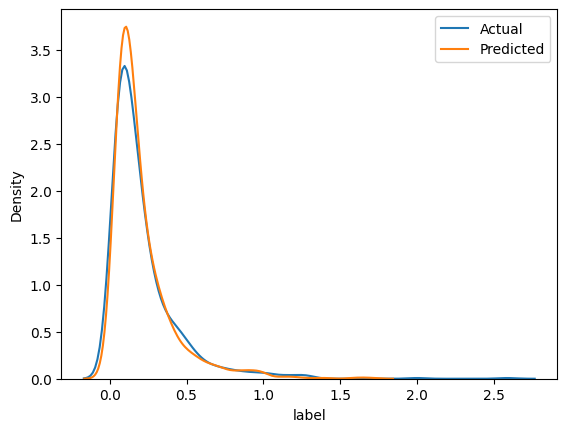

In [17]:
_=sns.kdeplot(X_test['label'], label = 'Actual')

_=sns.kdeplot(val_pre,label='Predicted')
_=plt.legend()

### Feature importances

In [18]:
def feature_imp_plot(df,feat_imp_score,title="" ):
    _=plt.figure(figsize=(12,6))
    feat_importance=pd.DataFrame({'columns':df.columns,'score':feat_imp_score})
    feat_importance=feat_importance.sort_values('score',ascending=False)
    _=sns.barplot(data=feat_importance.nlargest(10,'score'),x='score',y='columns')
    plt.title(f"{title}",fontsize=16);

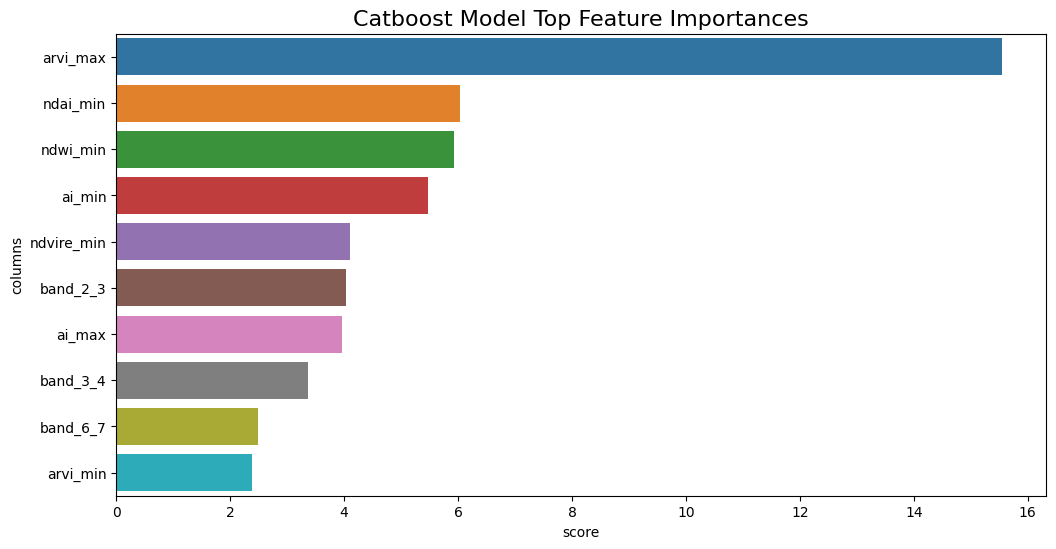

In [19]:
feature_imp_plot(x_train_feat,cat_reg.get_feature_importance(),"Catboost Model Top Feature Importances")

### Test data prediction

In [20]:
test_feat = pre_process_data(test,test_path)

100%|██████████| 1489/1489 [00:23<00:00, 64.57it/s]


In [38]:
test_pre=np.clip(cat_reg.predict(test_feat),a_min=0.003571, a_max=3.0)

In [39]:
sub = pd.DataFrame({'fielname':test['filename'],'AOD':test_pre})

In [40]:
sub.head()

,fielname,AOD
0,test_1.tif,0.102197
1,test_2.tif,0.206317
2,test_3.tif,0.226866
3,test_4.tif,0.090954
4,test_5.tif,0.090669


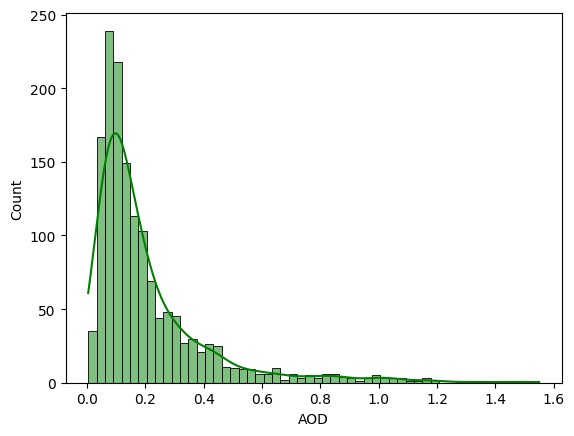

In [41]:
sns.histplot(sub['AOD'], kde=True,color='green');

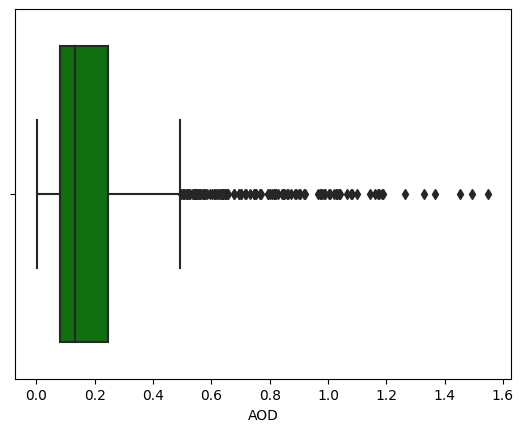

In [42]:
sns.boxplot(x=sub['AOD'],color='green');

In [43]:
sub['AOD'].describe()

count    1489.000000
mean        0.206792
std         0.210644
min         0.003571
25%         0.081294
50%         0.133686
75%         0.246462
max         1.549684
Name: AOD, dtype: float64

In [44]:
sub.to_csv("spectral_texture_slope_features_catboost_model_1.csv",index=False,header=False)